# Overview

This is a basic exercise to try and implement a simple version of VGG using the Keras API, going by the Simonyan ICLR2015 [paper](https://arxiv.org/pdf/1409.1556.pdf).

Uses the tensorflow tutorial from [here](https://www.tensorflow.org/tutorials/quickstart/beginner) as a guide, using a subset of the [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) dataset from kaggle.

# Download Data from Kaggle

Here just downloading, unzipping and moving all dog and cat files into the relevant folders for use by the Keras ImageDataGenerator.


In [0]:
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
! kaggle competitions download -c dogs-vs-cats
! unzip train.zip  && rm train.zip

% cd train
! for f in *; do d="${f:0:3}"; mkdir -p "$d"; mv -t "$d" -- "$f"; done

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       
  inflating: train/dog.5520.jpg      
  inflating: train/dog.5521.jpg      

# Import data

In [0]:
import tensorflow as tf

from tensorflow.keras.regularizers import l2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten,\
    Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:
train_dir = '/content/train'

cats_dir = os.path.join(train_dir, 'cat')
dogs_dir = os.path.join(train_dir, 'dog')

cats_num = len(os.listdir(cats_dir))
dogs_num = len(os.listdir(dogs_dir))

total_samples = cats_num + dogs_num

print('total training cat images:', cats_num)
print('total training dog images:', dogs_num)

total training cat images: 12500
total training dog images: 12500


# Preprocessing

We use the `flow_from_directory` method to generate labelled batches of images. The labels are taken from the folder names, and each is a generator which fetches batches of `(X_train, y_train)` pairs from the training folder.

To preview an image, we can call `next()` on the generator to load up a batch from the folder.

In [3]:
batch_size = 64
img_size = 200
val_split = 0.3

data_gen = ImageDataGenerator(rescale=1./255,
                              validation_split=val_split)

train_it = data_gen.flow_from_directory(
    batch_size=batch_size, directory=train_dir,
    target_size=(img_size, img_size), subset='training',
    class_mode='binary')

val_it = data_gen.flow_from_directory(
    batch_size=batch_size, directory=train_dir,
    target_size=(img_size, img_size), subset='validation',
    class_mode='binary')

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


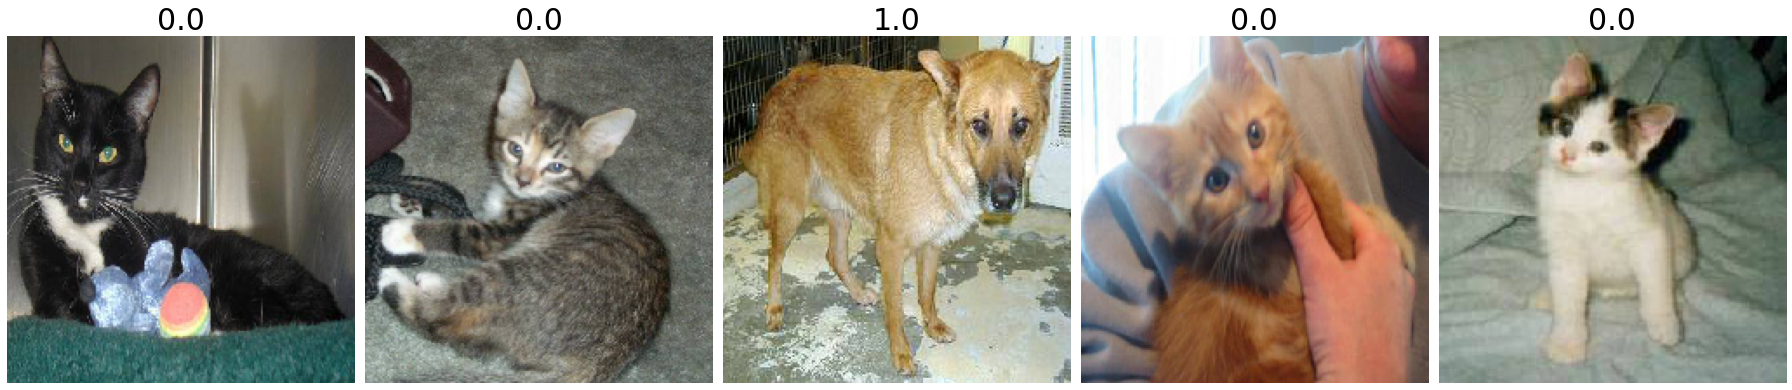

In [4]:
first_batch_images, labels = next(train_it)

def plot_images(images_arr, img_labels):
    fig, axes = plt.subplots(1, 5, figsize=(25,25))
    axes = axes.flatten()
    for img, ax, l in zip(images_arr, axes, img_labels):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(l, fontdict={'fontsize': 30})
    plt.tight_layout()
    plt.show()
    
    
plot_images(first_batch_images[:5], labels[0:5])

# Train and evaluate models


## Helper Fuctions



In [0]:
def compile_model(model):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'])

    model.summary()


def fit_model(model, num_epochs):
    history = model.fit(
        train_it,
        steps_per_epoch=train_it.samples // batch_size,
        epochs=num_epochs,
        validation_data=val_it,
        validation_steps=val_it.samples // batch_size
    )
    return history

def plot_scores(history):
    fig, axes = plt.subplots(1, 2)
    vals = [['loss', 'val_loss'], ['accuracy', 'val_accuracy']]
    for ax, val, title in zip(axes, vals, ['loss', 'acc']):
        ax.plot(history.history[val[0]], label='training')
        ax.plot(history.history[val[1]], label='validation')
        ax.set_title(title)
        ax.legend()
    plt.show()

## Base Models

The models are:
* `base_model` - 3 conv layers followed by fully connected and output
* `vggA` - 8 conv layers, followed by 2 large fully connected and output (VGG-A in VGG paper).
* `vggA_reg` - `vggA` with regularisation - L2 weight shrinkage (`lambda=5e-4`) and dropout ratio set to 0.5)

All models trained with Adam and "normalised" initialisation (from [Glorot 2010](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf?source=post_page---------------------------)).

Learning rate set to .001.

In [16]:
l2_lambda = 5e-4

base = Sequential([
    Conv2D(32, 3, padding='same', activation='relu',
           input_shape=(img_size,img_size,3)
           ),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

vggA = Sequential([
    Conv2D(64, 3, padding='same', activation='relu',
           input_shape=(img_size,img_size,3)
           ),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    # Dropout(0.3),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(1, activation='sigmoid')
])

vggA_reg = Sequential([
    Conv2D(64, 3, padding='same', activation='relu',
           input_shape=(img_size,img_size,3),
           kernel_regularizer=l2(l2_lambda)
           ),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda)),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda)),
    Conv2D(256, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda)),
    MaxPooling2D(),
    Conv2D(512, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda)),
    Conv2D(512, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda)),
    MaxPooling2D(),
    Conv2D(512, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda)),
    Conv2D(512, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda)),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(4096, activation='relu',
           kernel_regularizer=l2(l2_lambda)),
    Dropout(0.5),
    Dense(4096, activation='relu',
           kernel_regularizer=l2(l2_lambda)),
    Dense(1, activation='sigmoid')
])

models_dict = {'base': base, 'vggA': vggA, 'vggA_reg': vggA_reg}
# check that models are good:
for name, model in models_dict.items():
    print('details for model: ', name)
    compile_model(model)
    print('\n\n')

details for model:  base
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
flatten_9 (Flatten)          

Epoch 1/30
273/273 [==============================] - 94s 346ms/step - loss: 0.6783 - accuracy: 0.6071 - val_loss: 0.5380 - val_accuracy: 0.7317
Epoch 2/30
273/273 [==============================] - 94s 346ms/step - loss: 0.5200 - accuracy: 0.7417 - val_loss: 0.4854 - val_accuracy: 0.7729
Epoch 3/30
273/273 [==============================] - 94s 344ms/step - loss: 0.4531 - accuracy: 0.7905 - val_loss: 0.4588 - val_accuracy: 0.7854
Epoch 4/30
273/273 [==============================] - 94s 343ms/step - loss: 0.3810 - accuracy: 0.8248 - val_loss: 0.4624 - val_accuracy: 0.7856
Epoch 5/30
273/273 [==============================] - 94s 344ms/step - loss: 0.3016 - accuracy: 0.8722 - val_loss: 0.4608 - val_accuracy: 0.8058
Epoch 6/30
273/273 [==============================] - 94s 343ms/step - loss: 0.2159 - accuracy: 0.9090 - val_loss: 0.5927 - val_accuracy: 0.8015
Epoch 7/30
273/273 [==============================] - 94s 344ms/step - loss: 0.1264 - accuracy: 0.9535 - val_loss: 0.6913 - val_ac

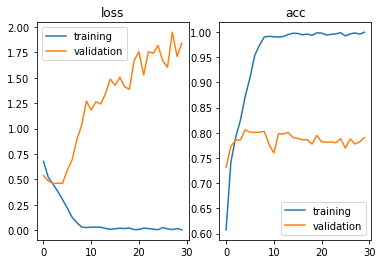

Epoch 1/30
273/273 [==============================] - 219s 801ms/step - loss: 0.7082 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4984
Epoch 2/30
273/273 [==============================] - 219s 803ms/step - loss: 0.7115 - accuracy: 0.4974 - val_loss: 0.6942 - val_accuracy: 0.4973
Epoch 3/30
273/273 [==============================] - 217s 797ms/step - loss: 0.6971 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 4/30
273/273 [==============================] - 218s 797ms/step - loss: 0.6937 - accuracy: 0.5038 - val_loss: 0.6930 - val_accuracy: 0.5180
Epoch 5/30
273/273 [==============================] - 217s 796ms/step - loss: 0.6938 - accuracy: 0.5045 - val_loss: 0.6932 - val_accuracy: 0.4992
Epoch 6/30
273/273 [==============================] - 217s 794ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 7/30
273/273 [==============================] - 216s 793ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6931 -

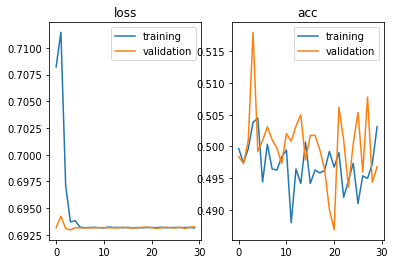

Epoch 1/30
273/273 [==============================] - 233s 853ms/step - loss: 1.8222 - accuracy: 0.4974 - val_loss: 1.0133 - val_accuracy: 0.4948
Epoch 2/30
273/273 [==============================] - 232s 849ms/step - loss: 0.8791 - accuracy: 0.4999 - val_loss: 0.7983 - val_accuracy: 0.4980
Epoch 3/30
273/273 [==============================] - 231s 846ms/step - loss: 0.7650 - accuracy: 0.4964 - val_loss: 0.7414 - val_accuracy: 0.4970
Epoch 4/30
273/273 [==============================] - ETA: 0s - loss: 0.7289 - accuracy: 0.4943

KeyboardInterrupt: ignored

In [0]:
num_epochs = 30
model_hists = {}

for name, model in models_dict.items():
    hist = fit_model(model, num_epochs)
    model_hists[name] = hist
    plot_scores(hist)

---

`base` shows good performance on training, poor peforming on validation. Needs regularisation.

Other models are unstable - possible problem with learning rate or initialisation, but the learning rate is quite low at .001 compared to other implementations of this, so we'll try different init and go with momentum.

## He init + SGD

Might work better with "He" initialisation, and using SGD with momentum, as in the original paper.

Models architecture same as previously.

In [17]:
l2_lambda = 5e-4

base_he = Sequential([
    Conv2D(32, 3, padding='same', activation='relu',
           input_shape=(img_size,img_size,3),
           kernel_initializer='he_uniform'
           ),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu',
           kernel_initializer='he_uniform'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu',
           kernel_initializer='he_uniform'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu',
           kernel_initializer='he_uniform'),
    Dense(1, activation='sigmoid')
])

vggA_he = Sequential([
    Conv2D(64, 3, padding='same', activation='relu',
           input_shape=(img_size,img_size,3),
           kernel_initializer='he_uniform'
           ),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu',
           kernel_initializer='he_uniform'),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu',
           kernel_initializer='he_uniform'),
    Conv2D(256, 3, padding='same', activation='relu',
           kernel_initializer='he_uniform'),
    MaxPooling2D(),
    Conv2D(512, 3, padding='same', activation='relu',
           kernel_initializer='he_uniform'),
    Conv2D(512, 3, padding='same', activation='relu',
           kernel_initializer='he_uniform'),
    MaxPooling2D(),
    Conv2D(512, 3, padding='same', activation='relu',
           kernel_initializer='he_uniform'),
    Conv2D(512, 3, padding='same', activation='relu',
           kernel_initializer='he_uniform'),
    MaxPooling2D(),
    Flatten(),
    # Dropout(0.3),
    Dense(4096, activation='relu',
          kernel_initializer='he_uniform'),
    Dense(4096, activation='relu',
          kernel_initializer='he_uniform'),
    Dense(1, activation='sigmoid')
])

vggA_reg_he = Sequential([
    Conv2D(64, 3, padding='same', activation='relu',
           input_shape=(img_size,img_size,3),
           kernel_regularizer=l2(l2_lambda),
           kernel_initializer='he_uniform'
           ),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda),
           kernel_initializer='he_uniform'),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda),
           kernel_initializer='he_uniform'),
    Conv2D(256, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda),
           kernel_initializer='he_uniform'),
    MaxPooling2D(),
    Conv2D(512, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda),
           kernel_initializer='he_uniform'),
    Conv2D(512, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda),
           kernel_initializer='he_uniform'),
    MaxPooling2D(),
    Conv2D(512, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda),
           kernel_initializer='he_uniform'),
    Conv2D(512, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda),
           kernel_initializer='he_uniform'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(4096, activation='relu',
          kernel_regularizer=l2(l2_lambda),
          kernel_initializer='he_uniform'),
    Dropout(0.5),
    Dense(4096, activation='relu',
          kernel_regularizer=l2(l2_lambda),
          kernel_initializer='he_uniform'),
    Dense(1, activation='sigmoid')
])

def compile_model_new(model):
    opt = tf.keras.optimizers.SGD(
    learning_rate=0.001, momentum=0.9)
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy'])

    model.summary()

models_dict_he = {'base_he': base_he, 'vggA_he': vggA_he,
                  'vggA_reg_he': vggA_reg_he}
# check that models are good:
for name, model in models_dict_he.items():
    print('details for model: ', name)
    compile_model_new(model)
    print('\n\n')

details for model:  base_he
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
flatten_12 (Flatten)     

details for  base
Epoch 1/30
273/273 [==============================] - 87s 317ms/step - loss: 0.6876 - accuracy: 0.5674 - val_loss: 0.6852 - val_accuracy: 0.5665
Epoch 2/30
273/273 [==============================] - 86s 314ms/step - loss: 0.6455 - accuracy: 0.6219 - val_loss: 0.6267 - val_accuracy: 0.6364
Epoch 3/30
273/273 [==============================] - 86s 315ms/step - loss: 0.6128 - accuracy: 0.6603 - val_loss: 0.5809 - val_accuracy: 0.6927
Epoch 4/30
273/273 [==============================] - 86s 316ms/step - loss: 0.5798 - accuracy: 0.6901 - val_loss: 0.5586 - val_accuracy: 0.7173
Epoch 5/30
273/273 [==============================] - 86s 317ms/step - loss: 0.5380 - accuracy: 0.7263 - val_loss: 0.5289 - val_accuracy: 0.7353
Epoch 6/30
273/273 [==============================] - 86s 315ms/step - loss: 0.5163 - accuracy: 0.7462 - val_loss: 0.5104 - val_accuracy: 0.7489
Epoch 7/30
273/273 [==============================] - 86s 314ms/step - loss: 0.4873 - accuracy: 0.7655 - val_los

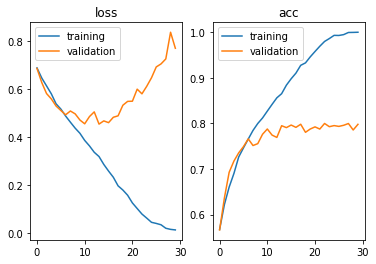




details for  vggA
Epoch 1/30
273/273 [==============================] - 215s 789ms/step - loss: 0.6605 - accuracy: 0.6137 - val_loss: 0.5774 - val_accuracy: 0.6911
Epoch 2/30
273/273 [==============================] - 214s 784ms/step - loss: 0.5657 - accuracy: 0.7017 - val_loss: 0.5345 - val_accuracy: 0.7292
Epoch 3/30
 18/273 [>.............................] - ETA: 2:42 - loss: 0.5984 - accuracy: 0.6667

KeyboardInterrupt: ignored

In [0]:
num_epochs = 30
model_hists_he = {}

for name, model in models_dict_he.items():
    print('details for ', name)
    hist = fit_model(model, num_epochs)
    model_hists_he[name] = hist
    plot_scores(hist)
    print('\n\n')

---

Once again, issue with big difference between vlaidation and training, so stopped early.

Let's see what increased regularisation does to `vggA_reg`:

## `vggA_reg` with MORE REGULARISATION!

from 5e-4 to 5e-3

In [18]:
l2_lambda = 5e-3

vggA_reg_he_m = Sequential([
    Conv2D(64, 3, padding='same', activation='relu',
           input_shape=(img_size,img_size,3),
           kernel_regularizer=l2(l2_lambda),
           kernel_initializer='he_uniform'
           ),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda),
           kernel_initializer='he_uniform'),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda),
           kernel_initializer='he_uniform'),
    Conv2D(256, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda),
           kernel_initializer='he_uniform'),
    MaxPooling2D(),
    Conv2D(512, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda),
           kernel_initializer='he_uniform'),
    Conv2D(512, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda),
           kernel_initializer='he_uniform'),
    MaxPooling2D(),
    Conv2D(512, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda),
           kernel_initializer='he_uniform'),
    Conv2D(512, 3, padding='same', activation='relu',
           kernel_regularizer=l2(l2_lambda),
           kernel_initializer='he_uniform'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(4096, activation='relu',
          kernel_regularizer=l2(l2_lambda),
          kernel_initializer='he_uniform'),
    Dropout(0.5),
    Dense(4096, activation='relu',
          kernel_regularizer=l2(l2_lambda),
          kernel_initializer='he_uniform'),
    Dense(1, activation='sigmoid')
])

compile_model_new(vggA_reg_he_m)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 200, 200, 64)      1792      
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 100, 100, 128)     73856     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 50, 50, 256)       295168    
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 50, 50, 256)       590080    
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 25, 25, 256)     

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 200, 200, 64)      1792      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 100, 100, 128)     73856     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 50, 50, 256)       295168    
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 50, 50, 256)       590080    
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 25, 25, 256)      

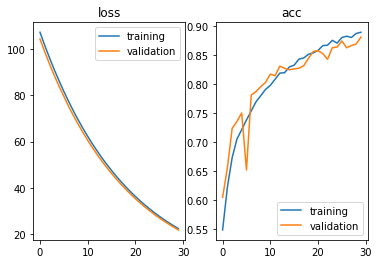

In [0]:
num_epochs = 30
vggA_reg_he_mh_hist = fit_model(vggA_reg_he_m, num_epochs)
plot_scores(vggA_reg_he_mh_hist)

Look at that smooooth oul loss! Hyup! She seemed to be increasing accuracy as she went so we could probably have left her run for longer.